# Here we are importing the stackoverflow data

In [1]:
import pandas as pd

df = pd.read_csv('../../data2/train.csv')

In [2]:
df.head(5)

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


In [3]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Q'] = le.fit_transform(df['Y']) 

In [4]:
df['Q'].value_counts()

0    15000
1    15000
2    15000
Name: Q, dtype: int64

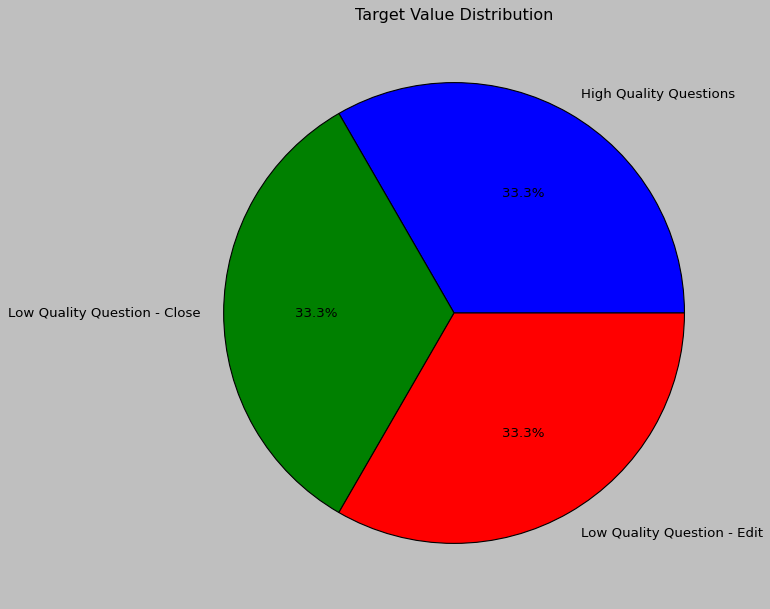

In [5]:
import matplotlib.pyplot as plt


labels = ['High Quality Questions', 'Low Quality Question - Close', 'Low Quality Question - Edit']
values = [len(df[df['Q'] == 2]), len(df[df['Q'] == 0]), len(df[df['Q'] == 1])]

plt.style.use('classic')
plt.figure(figsize=(16, 9))
plt.pie(x=values, labels=labels, autopct="%1.1f%%")
plt.title("Target Value Distribution")
plt.show()

In [5]:
df['text'] = df['Title'] + ' ' + df['Body']
df = df.drop(['Title', 'Body', 'Id', 'Tags', 'CreationDate'], axis=1)
df.head()

,Y,Q,text
0,LQ_CLOSE,1,Java: Repeat Task Every Random Seconds <p>I'm ...
1,HQ,0,Why are Java Optionals immutable? <p>I'd like ...
2,HQ,0,Text Overlay Image with Darkened Opacity React...
3,HQ,0,Why ternary operator in swift is so picky? <p>...
4,HQ,0,hide/show fab with scale animation <p>I'm usin...


In [6]:
import re

def clean(text):
    text = text.lower()
    text = re.sub(r'[^(a-zA-Z)\s]', '', text)
    return text

df['text'] = df['text'].apply(clean)

In [7]:
df.head()

,Y,Q,text
0,LQ_CLOSE,1,java repeat task every random seconds pim alre...
1,HQ,0,why are java optionals immutable pid like to u...
2,HQ,0,text overlay image with darkened opacity react...
3,HQ,0,why ternary operator in swift is so picky pthe...
4,HQ,0,hideshow fab with scale animation pim using cu...


In [132]:
type(r'df["text"][0]')

str

In [8]:
X = df['text']

In [9]:
y=df['Y']

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

In [11]:
import pickle

f = open('models/vectorizer', 'wb')
pickle.dump(vectorizer, f)

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(31500, 336402) (13500, 336402) (31500,) (13500,)


In [25]:
import pickle

f = open('temp/x_test.dat', 'wb')
pickle.dump(x_test, f)
f.close()

In [26]:
f = open('temp/y_test.dat', 'wb')
pickle.dump(y_test, f)
f.close()

# We are trying a few ML models to train on our data

In [27]:
from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression(C=1., n_jobs=-1)
lr_classifier.fit(x_train, y_train)

LogisticRegression(n_jobs=-1)

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

# Predict the labels of the test set: y_pred
y_pred = lr_classifier.predict(x_test)
# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test,y_pred))

[[3856  546   91]
 [ 635 3444  379]
 [  89   41 4419]]
              precision    recall  f1-score   support

          HQ       0.84      0.86      0.85      4493
    LQ_CLOSE       0.85      0.77      0.81      4458
     LQ_EDIT       0.90      0.97      0.94      4549

    accuracy                           0.87     13500
   macro avg       0.87      0.87      0.87     13500
weighted avg       0.87      0.87      0.87     13500

0.8680740740740741


In [30]:
lr_classifier.best_score = accuracy_score(y_test,y_pred)

In [18]:
print(f"Validation Accuracy of Logistic Regression Classifier is: {(lr_classifier.score(x_test, y_test)) * 100:.2f}%")

Validation Accuracy of Logistic Regression Classifier is: 86.81%


In [33]:
import pickle

f = open('models/logistic_reg', 'wb')
pickle.dump(lr_classifier, f)
f.close()

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty': ['l1','l2','elastic'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

logreg = LogisticRegression(random_state=2020)

# Instantiate the GridSearchCV object: logreg_cv
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, random_state=2020,shuffle=True)

logreg_cv = GridSearchCV(logreg, param_grid, cv=kfold,scoring="accuracy", verbose=True, n_jobs=-1)

# Fit it to the data
logreg_cv.fit(X,y)

print(logreg_cv.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
0.8792222222222221


In [24]:
print(f"Validation Accuracy of Logistic Regression Grid Search  is: {(logreg_cv.best_score_) * 100:.2f}%")

Validation Accuracy of Logistic Regression Grid Search  is: 87.92%


In [26]:
import pickle

f = open('models/logistic_reg', 'ab')
pickle.dump(logreg_cv, f)
f.close()

In [19]:
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve
import random

def plot_metric(clf, testX, testY, name):

    styles = ['bmh', 'classic', 'fivethirtyeight', 'ggplot']

    plt.style.use(random.choice(styles))
    plot_confusion_matrix(clf, testX, testY)
    plt.title(f"Confusion Matrix [{name}]")

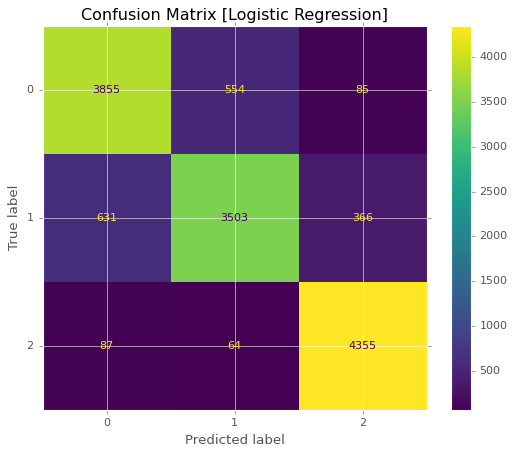

In [20]:
plot_metric(lr_classifier, x_test, y_test, "Logistic Regression")

In [28]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()
nb_classifier.fit(x_train, y_train)

MultinomialNB()

In [29]:
print(f"Validation Accuracy of Naive Bayes Classifier is: {(nb_classifier.score(x_test, y_test)) * 100:.2f}%")

Validation Accuracy of Naive Bayes Classifier is: 77.41%


In [32]:
nb_classifier.best_score = nb_classifier.score(x_test, y_test)

In [33]:
print(nb_classifier.best_score)

0.7741481481481481


In [35]:
import pickle

f = open('models/naive_bayes', 'ab')
pickle.dump(nb_classifier, f)
f.close()

In [36]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import numpy as np


param_grid = {'alpha': np.linspace(0, 10, 20)}

mnb = MultinomialNB()

# Instantiate the GridSearchCV object: mnb_cv
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, random_state=2020,shuffle=True)

mnb_cv = GridSearchCV(mnb, param_grid, cv=kfold,scoring="accuracy", verbose=True, n_jobs=-1)

# Fit it to the data
mnb_cv.fit(X,y)

print(mnb_cv.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0.7864


In [37]:
print(f"Validation Accuracy of Logistic Regression Grid Search  is: { (mnb_cv.best_score_)* 100:.2f}%")

Validation Accuracy of Logistic Regression Grid Search  is: 78.64%


In [11]:
import pickle

f = open('models/gridcv/naive_bayes', 'ab')
pickle.dump(mnb_cv, f)
f.close()

In [38]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_jobs=-1)

rf_classifier.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [39]:
print(f"Validation Accuracy of Random Forest Classifier is: {(rf_classifier.score(x_test, y_test)) * 100:.2f}%")

Validation Accuracy of Random Forest Classifier is: 82.86%


In [40]:
rf_classifier.best_score = rf_classifier.score(x_test, y_test)

In [42]:
import pickle

f = open('models/random_forest', 'ab')
pickle.dump(rf_classifier, f)
f.close()

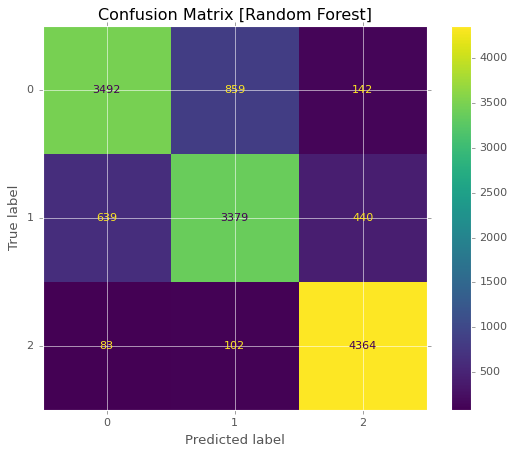

In [33]:
plot_metric(rf_classifier, x_test, y_test, "Random Forest")

In [ ]:
%%timeit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np


parameters = {'max_features': ['sqrt', 'log2']}

from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, random_state=2020,shuffle=True)

model_rf = RandomForestClassifier(random_state=2020)
cv = GridSearchCV(model_rf, param_grid=parameters,
                  cv=kfold,scoring='accuracy', n_jobs=-1, verbose=True)

cv.fit( X , y )

print(cv.best_score_ * 100)

Error: Pip module Unable to parse debugpy output, please log an issue with https://github.com/microsoft/vscode-jupyter is required for debugging cells. You will need to install it to debug cells.

In [13]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state=2020)
dt_classifier.fit(x_train, y_train)

DecisionTreeClassifier(random_state=2020)

In [15]:
print(f"Validation Accuracy of Decision Tree Classifier is: {(dt_classifier.score(x_test, y_test)) * 100:.2f}%")

Validation Accuracy of Decision Tree Classifier is: 79.81%


In [14]:
dt_classifier.best_score = dt_classifier.score(x_test, y_test)

In [17]:
import pickle

f = open('models/decision_tree', 'ab')
pickle.dump(dt_classifier, f)
f.close()

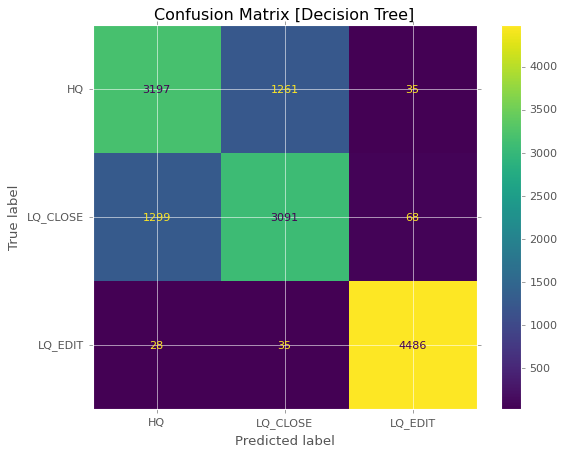

In [20]:
plot_metric(dt_classifier, x_test, y_test, "Decision Tree")

In [21]:
from sklearn.neighbors import KNeighborsClassifier

for k in range(1, 20):
    print("For K = ", k)
    knn_classifier = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)

    knn_classifier.fit(x_train, y_train)
        
    print(f"Validation Accuracy of KNeighbors Classifier is: {(knn_classifier.score(x_test, y_test)) * 100:.2f}%")

For K =  1
Validation Accuracy of KNeighbors Classifier is: 52.27%
For K =  2
Validation Accuracy of KNeighbors Classifier is: 54.53%
For K =  3
Validation Accuracy of KNeighbors Classifier is: 55.33%
For K =  4
Validation Accuracy of KNeighbors Classifier is: 56.59%
For K =  5
Validation Accuracy of KNeighbors Classifier is: 57.41%
For K =  6
Validation Accuracy of KNeighbors Classifier is: 57.93%
For K =  7
Validation Accuracy of KNeighbors Classifier is: 58.32%
For K =  8
Validation Accuracy of KNeighbors Classifier is: 58.79%
For K =  9
Validation Accuracy of KNeighbors Classifier is: 59.31%
For K =  10
Validation Accuracy of KNeighbors Classifier is: 59.43%
For K =  11
Validation Accuracy of KNeighbors Classifier is: 59.75%
For K =  12
Validation Accuracy of KNeighbors Classifier is: 59.48%
For K =  13
Validation Accuracy of KNeighbors Classifier is: 59.71%
For K =  14
Validation Accuracy of KNeighbors Classifier is: 60.11%
For K =  15
Validation Accuracy of KNeighbors Classifier 

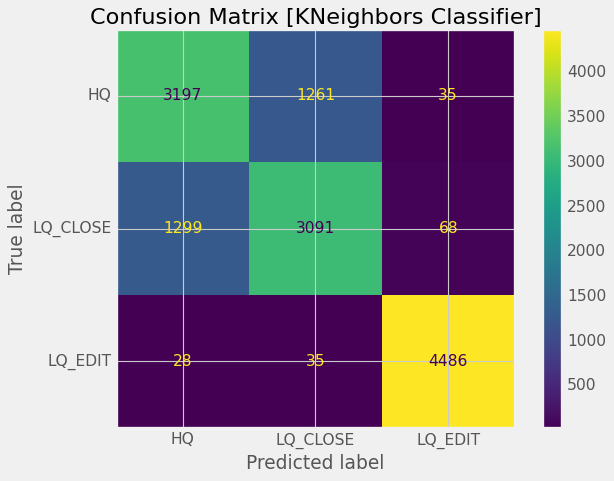

In [22]:
plot_metric(dt_classifier, x_test, y_test, "KNeighbors Classifier")

In [16]:
from sklearn.model_selection import GridSearchCV
import numpy as np

parameters = {'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree'], 'n_neighbors': np.arange(6, 20)}

from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier()

from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, random_state=2020,shuffle=True)

cv = GridSearchCV(knn_classifier, param_grid=parameters,
                  cv=kfold,scoring='accuracy', n_jobs=-1, verbose=True)

cv.fit( X , y )

print(cv.best_score_ * 100)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


In [23]:
from xgboost import XGBClassifier

xg_classifier = XGBClassifier(random_state=2020)
xg_classifier.fit(x_train, y_train)


[21:18:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=2020, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
print(f"Validation Accuracy of XGBClassifier Classifier is: {(xg_classifier.score(x_test, y_test)) * 100:.2f}%")

Validation Accuracy of XGBClassifier Classifier is: 87.90%


In [25]:
xg_classifier.best_score = xg_classifier.score(x_test, y_test)

In [27]:
import pickle

f = open('models/xgboost', 'ab')
pickle.dump(xg_classifier, f)
f.close()

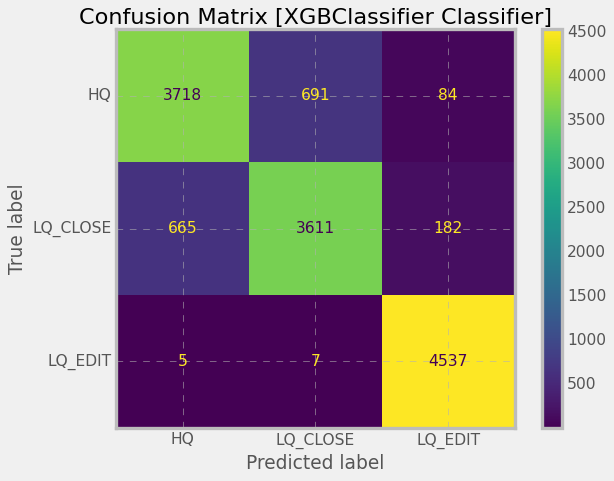

In [28]:
plot_metric(xg_classifier, x_test, y_test, "XGBClassifier Classifier")

In [9]:
import xgboost as xgb

# Create the DMatrix from X and y: cancer_dmatrix
stack_dmatrix = xgb.DMatrix(data=X, label=y)

print(stack_dmatrix)

In [21]:
# Create the parameter dictionary: params
params = {"objective":"multi:softmax", "max_depth":10, 'num_class': 3, 'feature_selector': ['cyclic', 'shuffle', 'random', 'greedy', 'thrifty']}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=stack_dmatrix, params=params, metrics="merror",
                  nfold=3, num_boost_round=5, as_pandas=True, seed=2020)

# Print cv_results
print(cv_results)

# # Print the accuracy
# print(((1-cv_results["test-error-mean"]).iloc[-1]))

[11:14:37] WARNING: ../src/learner.cc:541: 
Parameters: { feature_selector } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:14:39] WARNING: ../src/learner.cc:541: 
Parameters: { feature_selector } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:14:42] WARNING: ../src/learner.cc:541: 
Parameters: { feature_selector } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above c

In [29]:
from sklearn.svm import LinearSVC

svc = LinearSVC(verbose=1, C=1)
svc.fit(x_train, y_train)

[LibLinear]

LinearSVC(C=1, verbose=1)

In [30]:
svc.score(x_test, y_test) * 100

87.5111111111111

In [31]:
svc.best_score = svc.score(x_test, y_test)

In [33]:
import pickle

f = open('models/svc', 'ab')
pickle.dump(svc, f)
f.close()

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import VotingClassifier

dtc = DecisionTreeClassifier(random_state=2020)
logreg = LogisticRegression()
gauss = MultinomialNB()

Voting = VotingClassifier(estimators=[('DT',dtc),
                                      ('LR',logreg),
                                      ('GU',gauss)],voting='soft', verbose=True, n_jobs=-1)


In [22]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

Voting.fit(x_train,y_train)


y_pred = Voting.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test,y_pred))

[[3649  824   20]
 [1039 3346   73]
 [  44   30 4475]]
              precision    recall  f1-score   support

          HQ       0.77      0.81      0.79      4493
    LQ_CLOSE       0.80      0.75      0.77      4458
     LQ_EDIT       0.98      0.98      0.98      4549

    accuracy                           0.85     13500
   macro avg       0.85      0.85      0.85     13500
weighted avg       0.85      0.85      0.85     13500

0.8496296296296296


In [23]:
Voting.best_score = accuracy_score(y_test,y_pred)

In [24]:
import pickle

f = open('models/voting', 'ab')
pickle.dump(Voting, f)
f.close()

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import BaggingClassifier


model_bg = BaggingClassifier(random_state=2020,oob_score=True,
                             max_features=x_train.shape[1],
                             n_estimators=15,max_samples=x_train.shape[0])

#OR for any other model bagging
from sklearn.linear_model import LogisticRegression

model_bg = BaggingClassifier(base_estimator = LogisticRegression() ,
                             random_state=2020,oob_score=True,
                             max_features=x_train.shape[1],
                             n_estimators=15,max_samples=x_train.shape[0], n_jobs=-1)
                             
model_bg.fit( x_train , y_train )

print("Out of Bag Score = " + "{:.4f}".format(model_bg.oob_score_))

y_pred = model_bg.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))


Out of Bag Score = 0.8626
[[3837  561   95]
 [ 626 3431  401]
 [  96   44 4409]]
              precision    recall  f1-score   support

          HQ       0.84      0.85      0.85      4493
    LQ_CLOSE       0.85      0.77      0.81      4458
     LQ_EDIT       0.90      0.97      0.93      4549

    accuracy                           0.86     13500
   macro avg       0.86      0.86      0.86     13500
weighted avg       0.86      0.86      0.86     13500

0.8649629629629629


In [40]:
model_bg.best_score = accuracy_score(y_test, y_pred)

In [41]:
model_bg.best_score

0.8649629629629629

In [42]:
import pickle

f = open('models/bagging', 'ab')
pickle.dump(model_bg, f)
f.close()

In [43]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

from sklearn.svm import LinearSVC
svc = LinearSVC(random_state=2020)

from sklearn.naive_bayes import MultinomialNB
gaussian = MultinomialNB()

from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=2020,max_depth = 10)


from xgboost import XGBClassifier
clf = XGBClassifier(random_state=2000)

from sklearn.ensemble import StackingClassifier
models_considered = [('Logistic Regression', logreg),
                     ('LinearSVC', svc),('Naive Bayes',gaussian),
                     ('Decision Tree',dtc),
                     ('XGBoost',clf)]


from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, random_state=2020,shuffle=True)

stack = StackingClassifier(estimators = models_considered,cv = kfold,
                           final_estimator=clf,stack_method="predict", n_jobs=-1)

stack.fit(x_train,y_train)

[21:59:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=2020, shuffle=True),
                   estimators=[('Logistic Regression', LogisticRegression()),
                               ('LinearSVC', LinearSVC(random_state=2020)),
                               ('Naive Bayes', MultinomialNB()),
                               ('Decision Tree',
                                DecisionTreeClassifier(max_depth=10,
                                                       random_state=2020)),
                               ('XGBoost',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_byl...
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                     

In [44]:
stack.best_score = stack.score(x_test, y_test)

In [45]:
stack.best_score

0.8972592592592593

In [47]:
import pickle

f = open('models/stack', 'ab')
pickle.dump(stack, f)
f.close()

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(3,3,2),activation='tanh',
                    random_state=2020)
mlp.fit( x_train , y_train )
y_pred = mlp.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[3578  846   69]
 [ 658 3396  404]
 [ 109  120 4320]]
              precision    recall  f1-score   support

          HQ       0.82      0.80      0.81      4493
    LQ_CLOSE       0.78      0.76      0.77      4458
     LQ_EDIT       0.90      0.95      0.92      4549

    accuracy                           0.84     13500
   macro avg       0.83      0.84      0.83     13500
weighted avg       0.83      0.84      0.84     13500

0.8365925925925926


In [35]:
mlp.best_score = accuracy_score(y_test, y_pred)

In [36]:
mlp.best_score

0.8365925925925926

In [37]:
import pickle

f = open('models/mlp', 'ab')
pickle.dump(mlp, f)
f.close()

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(3,3,2),activation='tanh',
                    random_state=2020)
mlp.fit( x_train , y_train )
y_pred = mlp.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[3584  605  304]
 [ 551 3142  765]
 [ 193  436 3920]]
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      4493
           1       0.75      0.70      0.73      4458
           2       0.79      0.86      0.82      4549

    accuracy                           0.79     13500
   macro avg       0.79      0.79      0.79     13500
weighted avg       0.79      0.79      0.79     13500

0.7885925925925926


In [18]:
import numpy as np
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier

lr_range = np.linspace(0.001,0.8,10)
lr_method = ['constant','invscaling','adaptive']
hl_range = [(4,3,2),(3,2),(5,4,3,2),(10,5,3)]
act_range = ['logistic','tanh']
parameters = dict(learning_rate_init=lr_range,
                  hidden_layer_sizes = hl_range,
                  activation = act_range, 
                  learning_rate=lr_method)

from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)

mlp = MLPClassifier(random_state=2019,learning_rate='constant')
mlpGrid = GridSearchCV(mlp, param_grid=parameters, cv=kfold,
                       scoring='accuracy',verbose=True, n_jobs=-1)
mlpGrid.fit(X, y)

# # Best Parameters
# print(mlpGrid.best_params_)

print(mlpGrid.best_score_)

# best_model = mlpGrid.best_estimator_

# # Weights
# print(best_model.coefs_)
# print(best_model.intercepts_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


In [23]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(x_train, x_test, y_train, y_test)
models

ModuleNotFoundError: No module named 'lazypredict.Supervised'

In [142]:
df.head()

,Y,Q,text
0,LQ_CLOSE,1,java repeat task every random seconds pim alre...
1,HQ,0,why are java optionals immutable pid like to u...
2,HQ,0,text overlay image with darkened opacity react...
3,HQ,0,why ternary operator in swift is so picky pthe...
4,HQ,0,hideshow fab with scale animation pim using cu...


In [155]:
df2 = pd.read_csv('stack.csv')
df2

,Title,Body,Y
0,Java: Repeat Task Every Random Seconds,<p>I\'m already familiar with repeating tasks ...,LQ_CLOSE


In [ ]:
df2['text'] = df2['Title'] + ' ' + df2['Body']